# Analyzing Youtube Comments in R

In this notebook, we will interactively walk trough the analysis of Youtube comments. For instructions on how to
download and parse the data, please refer to the R script in this repository. The scripts are part of an ongoing research project:

https://www.researchgate.net/project/Methods-and-Tools-for-Automatic-Sampling-and-Analysis-of-YouTube-Comments

and will be subject to change. If you use substantive parts of this notebook or the accompanying script as part of your own research, please cite it in the following way:

Kohne, J., Breuer, J., & Mohseni, M. R. (2019). Methods and Tools for Automatic Sampling and Analysis of YouTube User Comments: https://doi.org/10.17605/OSF.IO/HQSXE

***

## Importing packages

First of all, we need to import and attach some necessary packages for text data analysis and visualization

In [ ]:
# CRAN packages
packages <- c("devtools", "tm", "quanteda", "tuber","qdapRegex","rlang","purrr","ggplot2", "syuzhet", "lexicon") # create list of required packages
for (package in packages) { # check if those packages are already installed
  if (!require(package, character.only=T)) { # if not, install & load them
    install.packages(package)
    library(package, character.only=T)
  }
  else {library(package, character.only=T)} # if they are already installed, only load them
}
rm(packages, package) 


In [ ]:
# GitHub packages
install_github("hadley/emo") # install from GitHub
library(emo) # load the emo package

# Installing the emoGG package from github (not on CRAN yet): Displays Emoji in ggplot objects
devtools::install_github("dill/emoGG") # install from GitHub
library(emoGG) # load the emo package

***

## Setting Options

Because we are working with text data, we need to set some options so that text is not interpreted as categorical
variables by R

In [ ]:
options(stringAsFactors = FALSE)

***

## Importing Data

In this notebook, we will work with a saved version of an already parsed dataframe. Please check the R script
in this notebook for a walktrough of how to extract data from youtube and parse it. We will be using the comments of this video, extracted in January 2019:

https://www.youtube.com/watch?v=DcJFdCmN98s 

In [ ]:
# Loading prepared dataset, the dataframe is named "FormattedComments"
load("ParsedCommentsUTF8.Rdata")

***

## Analyzing Youtube Comments

#### Overview

First, lets have a look at an excerpt of the data to see how it is structured. We will display the
first 10 rows of the dataframe

In [94]:
# showing first 10 rows of dataframe
head(FormattedComments,10)

Author,Text,TextEmojiReplaced,TextEmojiDeleted,Emoji,LikeCount,URL,Published,Updated,ModerationStatus,CommentID
schmoyoho,"You can download & stream the track for all your dance party needs 🔥: https://itunes.apple.com/us/album/oh-my-dayum-single/553920419 (but it's not on Tidal, sorry) HIGH FIVES & FIST BUMPS to everyone here & across the globe for getting this video to 25 million! to celebrate, i shall go run 25 million laps around the track, brb. next up, 25 billion (that's how numbers work, right?) The utmost props to @100908751642774375984 , we'll have to raise a glass to this next time we meet","You can download & stream the track for all your dance party needs EMOJI_Fire : https://itunes.apple.com/us/album/oh-my-dayum-single/553920419 (but it's not on Tidal, sorry) HIGH FIVES & FIST BUMPS to everyone here & across the globe for getting this video to 25 million! to celebrate, i shall go run 25 million laps around the track, brb. next up, 25 billion (that's how numbers work, right?) The utmost props to @100908751642774375984 , we'll have to raise a glass to this next time we meet","You can download & stream the track for all your dance party needs : https://itunes.apple.com/us/album/oh-my-dayum-single/553920419 (but it's not on Tidal, sorry) HIGH FIVES & FIST BUMPS to everyone here & across the globe for getting this video to 25 million! to celebrate, i shall go run 25 million laps around the track, brb. next up, 25 billion (that's how numbers work, right?) The utmost props to @100908751642774375984 , we'll have to raise a glass to this next time we meet",EMOJI_Fire,1015,https://....,2015-04-25 16:42:03,2018-07-12 18:48:23,NA,Ugj0RqORn9Vl5XgCoAEC
stereojpg,2019?,2019?,2019?,NA,0,NA,2019-02-14 14:52:08,2019-02-14 14:52:08,NA,UgxvhKSjcnw3bsfylHd4AaABAg
Slug,Skimalarinkadinkadinkadink skimalarinkadoo I love you!,Skimalarinkadinkadinkadink skimalarinkadoo I love you!,Skimalarinkadinkadinkadink skimalarinkadoo I love you!,NA,0,NA,2019-02-14 06:31:30,2019-02-14 06:31:30,NA,UgwqXcaQ35eYM_uPdQl4AaABAg
SpaceWalker 916,Youu bite the peach the peach bite back,Youu bite the peach the peach bite back,Youu bite the peach the peach bite back,NA,0,NA,2019-02-14 03:04:53,2019-02-14 03:04:53,NA,Ugz327hwc5fLXcp88dp4AaABAg
Billy Carrs,Still makes me happy,Still makes me happy,Still makes me happy,NA,0,NA,2019-02-13 23:50:31,2019-02-13 23:50:31,NA,UgxOSpSQU5S1VuDkoF54AaABAg
Robyn Gonzalez,My boyfriend and I quote this song on a daily basis. And I have no regrets,My boyfriend and I quote this song on a daily basis. And I have no regrets,My boyfriend and I quote this song on a daily basis. And I have no regrets,NA,0,NA,2019-02-13 16:27:26,2019-02-13 16:27:26,NA,UgwQZFfhZyUQeDPMoOB4AaABAg
Zones,2012 was the year ;_;,2012 was the year ;_;,2012 was the year ;_;,NA,0,NA,2019-02-13 10:31:08,2019-02-13 10:31:08,NA,Ugxm4QAR49MpPJ19NpN4AaABAg
ASilverCube,"My Recommendations have been on point lately, god bless, YT algorithm","My Recommendations have been on point lately, god bless, YT algorithm","My Recommendations have been on point lately, god bless, YT algorithm",NA,0,NA,2019-02-13 02:10:43,2019-02-13 02:10:43,NA,UgwXAQNOMZ-mU-b3O9R4AaABAg
gimme That,Please burger take me to those beautiful and gold moments of my life,Please burger take me to those beautiful and gold moments of my life,Please burger take me to those beautiful and gold moments of my life,NA,0,NA,2019-02-12 09:56:36,2019-02-12 09:56:36,NA,UgyH3vE44dZIntcBzAp4AaABAg
The Food Nomads A.K.A The Fomads,A musical masterpiece,A musical masterpiece,A musical masterpiece,NA,0,NA,2019-02-12 09:35:09,2019-02-12 09:35:09,NA,UgyRywV_PNLnag29Qhd4AaABAg


We can use all columns for our analysis, for example, we can use this plot now to see the number of new comments
over time

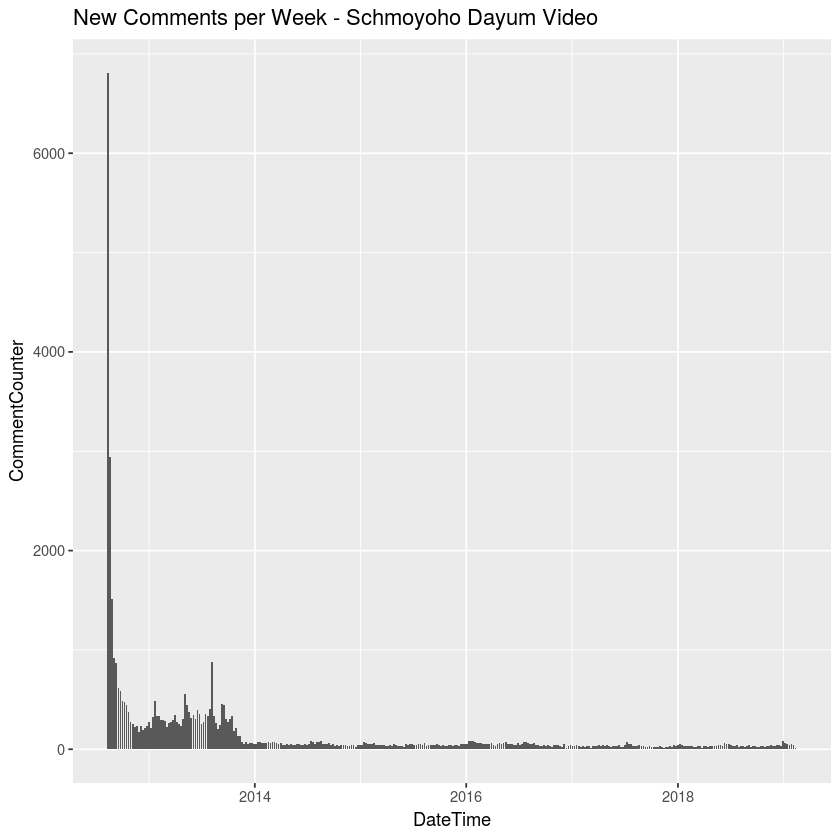

In [95]:
# Creating helper dataframe
CommentsCounter <- rep(1,dim(FormattedComments)[1])
CounterFrame <- data.frame(CommentsCounter,unlist(FormattedComments[,8]))
colnames(CounterFrame) <- c("CommentCounter","DateTime")

# binning by week
CounterFrame$DateTime <- as.Date(cut(CounterFrame$DateTime, breaks = "week"))

# plotting
ggplot(CounterFrame,aes(x=DateTime,y=CommentCounter)) +
  stat_summary(fun.y=sum,geom="bar") +
  scale_x_date() +
  ggtitle("New Comments per Week - Schmoyoho Dayum Video")

***

#### Basic Frequency Analysis for Text

In this section, we give a breif outline of text analysis for Youtube Comments.
This exemplary part is largely based on this tutorial:

https://docs.quanteda.io/articles/pkgdown/examples/plotting.html

We use the dataframe column without the Emojis for the pure textual analysis here

First of all, we need to remove new line commands from comment texts

In [ ]:
# Removing newline characters from comments
FormattedComments$TextEmojiDeleted <- gsub(FormattedComments$TextEmojiDeleted, pattern = "\\\n", replacement = " ")

Lets have a look at the first 10 comments in the dataframe (unordered)

In [96]:
# Listing first n comments in dataframe
as.list(head(FormattedComments$TextEmojiDeleted, n = 10))

[[1]]
[1] "You can download & stream the track for all your dance party needs : https://itunes.apple.com/us/album/oh-my-dayum-single/553920419 (but it's not on Tidal, sorry)  HIGH FIVES & FIST BUMPS to everyone here & across the globe for getting this video to 25 million! to celebrate, i shall go run 25 million laps around the track, brb. next up, 25 billion (that's how numbers work, right?) The utmost props to @100908751642774375984 , we'll have to raise a glass to this next time we meet"

[[2]]
[1] "2019?"

[[3]]
[1] "Skimalarinkadinkadinkadink skimalarinkadoo I love you!"

[[4]]
[1] "Youu bite the peach the peach bite back"

[[5]]
[1] "Still makes me happy"

[[6]]
[1] "My boyfriend and I quote this song on a daily basis. And I have no regrets"

[[7]]
[1] "2012 was the year ;_;"

[[8]]
[1] "My Recommendations have been on point lately, god bless, YT algorithm"

[[9]]
[1] "Please burger take me to those beautiful and gold moments of my life"

[[10]]
[1] "A musical masterpiece"

Next, we need to tokenize the comments (i.e., split them up into individual chunks, seperated by a space)
This step also simplifies the text by:
-  removing all numbers
-  removing all punctuation
-  removing all non-character symbols
-  removing all hyphens
-  removing all URLs 

the idea is that each token will be an individual word

In [ ]:
# Tokenizing the comments
# for more information and options check:
# https://www.rdocumentation.org/packages/quanteda/versions/1.4.0/topics/tokens

toks <- tokens(char_tolower(FormattedComments$TextEmojiDeleted),
               remove_numbers = TRUE,
               remove_punct = TRUE,
               remove_separators = TRUE,
               remove_symbols = TRUE,
               remove_hyphens = TRUE,
               remove_url = TRUE)

Next, we build a document-term matrix and remove stopwords. For more information see:

https://en.wikipedia.org/wiki/Document-term_matrix

https://en.wikipedia.org/wiki/Stop_words)

Stopwords are very frequent words that appear in almost all texts (e.g. "a","but","it").
These words occur with about the same frequency in all kinds of texts and are thus not very informative.

In [ ]:
# Creating Document-term frequency matrix
commentsDfm <- dfm(toks, remove = quanteda::stopwords("english"))

We now have a matrix where each column represents a each token that occurs at least once in the collcetion of comments and each row represents a comment. If a token is contained in a comment, the respective cell has a 1 and if a token is not contained in a comment the respective cell will contain a 0.

We can use this document-term matrix to visualize the occurance of tokens

In [97]:
# Displaying the n most frequent tokens
TermFreq <- textstat_frequency(commentsDfm)
head(TermFreq, n = 20)

feature,frequency,rank,docfreq,group
dayum,9618,1,5876,all
guys,4553,2,4332,all
song,3622,3,3415,all
five,3240,4,3114,all
burger,2984,5,2671,all
like,2389,6,2235,all
love,2179,7,2108,all
just,1949,8,1849,all
good,1660,9,1609,all
best,1646,10,1623,all


After inspecting the most frequent terms, we might want to exclude certain
terms that are not informative for us (e.g. the word "video") or are
artifacts of online communication (e.g. xd or d as leftovers of smilies)

In [ ]:
# This is just an example, you can (and should) create your own list for each video
CustomStops <- c("video","oh","d","now","get","go","xd", "youtube", "lol")

In [ ]:
# We can create another document-frequency matrix that excludes the custom stopwords that we just defined,
commentsDfm <- dfm(toks, remove = c(quanteda::stopwords("english"),CustomStops))

In [98]:
# Recalculating and displaying the n most frequent tokens
TermFreq <- textstat_frequency(commentsDfm)
head(TermFreq, n = 20)

feature,frequency,rank,docfreq,group
dayum,9618,1,5876,all
guys,4553,2,4332,all
song,3622,3,3415,all
five,3240,4,3114,all
burger,2984,5,2671,all
like,2389,6,2235,all
love,2179,7,2108,all
just,1949,8,1849,all
good,1660,9,1609,all
best,1646,10,1623,all


Next, we can visualize the frequency of tokens with some plots,
first of all, lets check the overall frequency across all comments

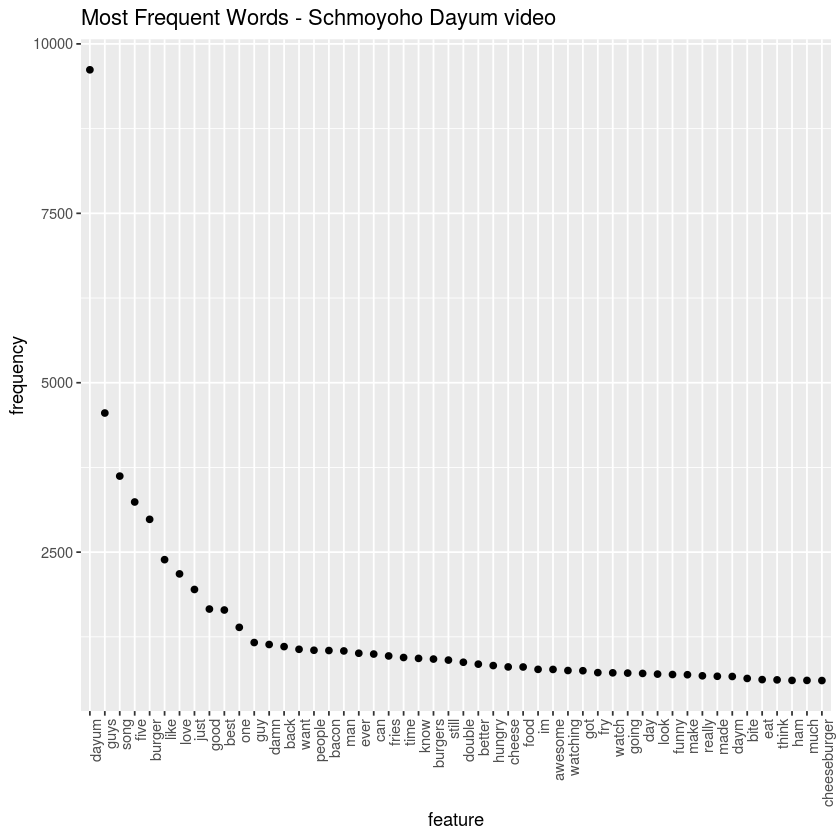

In [99]:
# Sort by reverse frequency order (i.e., from most to least frequent)
TermFreq$feature <- with(TermFreq, reorder(feature, -frequency))

# Plot frequency of 50 most common words
ggplot(head(TermFreq, n = 50), aes(x = feature, y = frequency)) + # you can change n to choose how many words are plotted
  geom_point() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("Most Frequent Words - Schmoyoho Dayum video")

With the above method, weŕe only counting the overall occurance across all comments. This might be biased
by some users spamming the same tokens many times in the same comment while other comments might not contain
the term at all. To see whether this is a problem in our data, lets plot the number of comments in which each
token occurs at least once

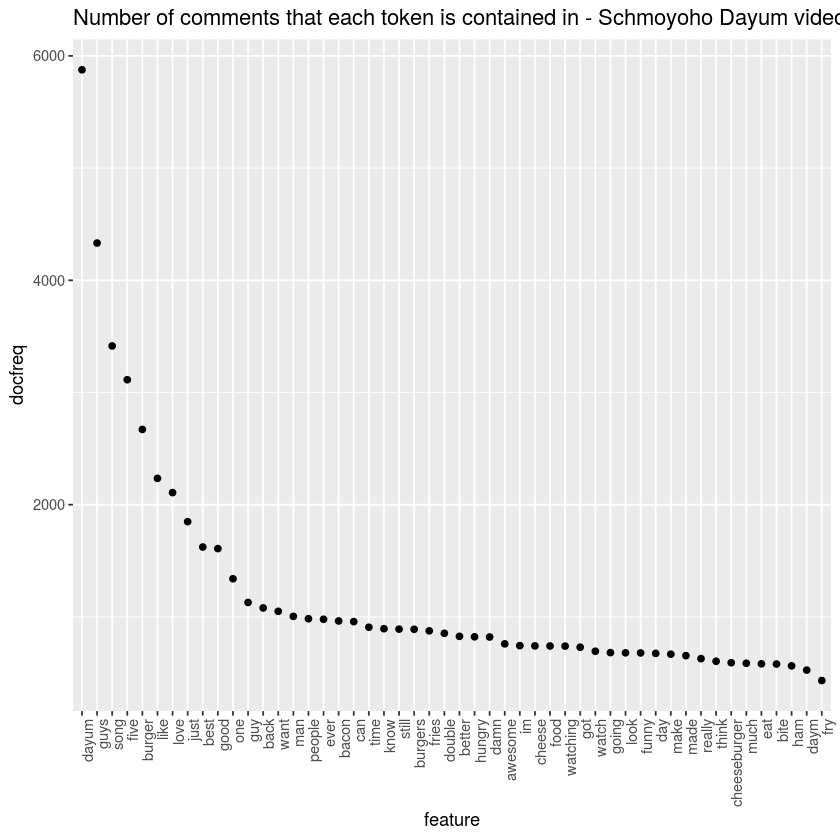

In [100]:
# sort by reverse document frequency order (i.e., from most to least frequent)
TermFreq$feature <- with(TermFreq, reorder(feature, -docfreq))

# plot terms that appear in the highest number of comments
ggplot(head(TermFreq, n = 50), aes(x = feature, y = docfreq)) + # you can change n to choose how many words are plotted 
  geom_point() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("Number of comments that each token is contained in - Schmoyoho Dayum video")

By manual inspection, we do not see any extreme deviations, even though this is a completely subjective
assessment. Whether you want to rely on overall frequency or on document frequency for your analysis depends
on your research question, your data and your personal assessment. We will continue to use the overall frequency
in this notebook.

We can also use our document-term frequency matrix to generate a wordcloud of the most common tokens

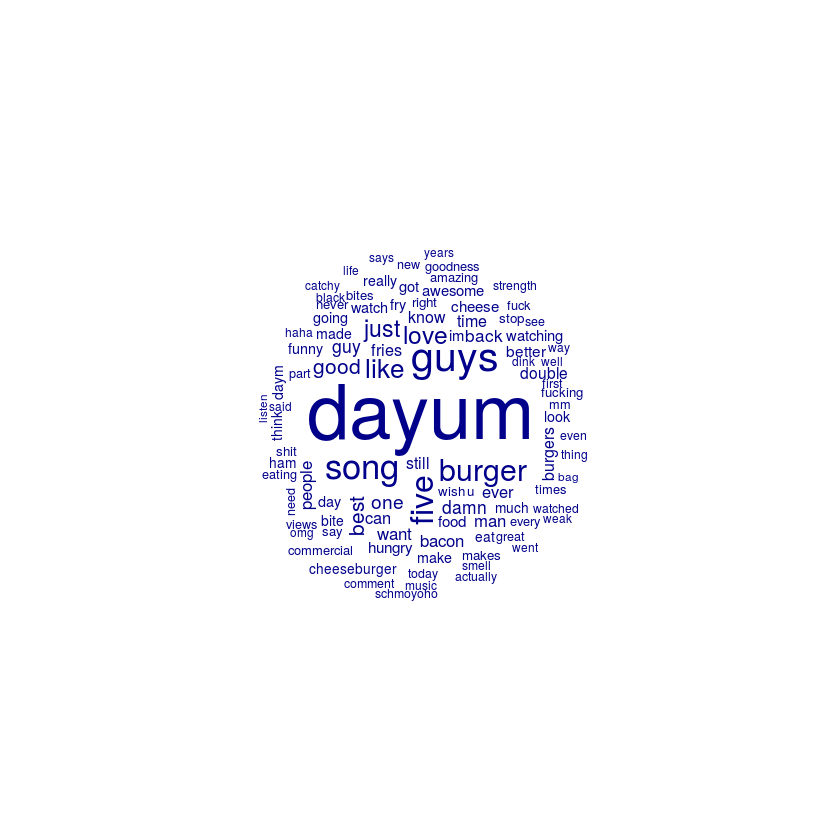

In [101]:
# Setting a random seed to make the wordcloud reproducible (this can be any number)
set.seed(12345)

# Creating wordcloud
textplot_wordcloud(dfm_select(commentsDfm, min_nchar=1),
                   random_order=FALSE,
                   max_words=100)

***

#### Sentiment Analysis for Text

We want to compute sentiment scores per comment. This is done by matching the textstrings with a dictionary of word sentiments and adding them up per document (in our case comments). Depending on the type of content you want to analyze, a different sentiment dictionary might be suitable. For Youtube videos, we decided to use the AFINN dictionary: 

http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010

For more options, check:

https://www.rdocumentation.org/packages/syuzhet/versions/1.0.4/topics/get_sentiment 

In [ ]:
# computing Sentiment Scores
CommentSentiment <- get_sentiment(FormattedComments$TextEmojiDeleted, method = "afinn")

First of all, lets get an overview of the sentiment scores per comment

In [ ]:
# summary statistics for sentiment scores per comment
summary(CommentSentiment)

In [104]:
# display comments with a sentiment score below x
x  <- -15
as.list(FormattedComments$TextEmojiDeleted[CommentSentiment < x])

[[1]]
[1] "Exude me vladdy3089... Racist is someone who believes in Racism... Bitch: Female Pregnant Dog, what dog?... Communist: how the fuck is politics involved?... Ass: what you shit out of, no need for ass"

[[2]]
[1] "I wish the radio would play all kinds of shit from youtube, but no THEY ALWAYS HAVE TO PLAY THE SAME FUCKING SONGS AT THE SAME FUCKING HOUR OF EVERY SAME MOTHERFUCKING BULLSHIT AIDS D SMOKIN CORNER CRACK WHORE DAY."

[[3]]
[1] "rape me?? what the fuck is wrong with that dude haskey i might call the police. he's fucked up in the head! Yeah and of course i'm bad because i'm against obesity, one of the worlds big problems -_-  that's actually good dude ! (warning dont rage i'l simply say back what you said to me) ---- > you should fuck off instead "

[[4]]
[1] "you know what, why dont you just go sit in a hole, watch your dumbass pornos and post stupid fucking bullshit all over youtube. do it every FUCKING day for all  care. youre making NADA but enemies and doing NOTHING in youre worthless shitty ass life. everybody FUCKING hates you."

[[5]]
[1] "No, it dosent mean I'm actually a fox, and you should know that. You are either a fail troll or an idiot. Also, white people may appear that way, but do you think the people they were racist too didn't think the same of them?  Also, generations have changed, racism is looked down apon, thats why I'm looking down on your dumb ass."

[[6]]
[1] "What. The. Fuck. I didn't even know that these kind of people still existed. I don't know about all 9gaggers, but what I have seen today has given me negative respect for it. I didn't think so many racist people even lived. This is ridiculous, you are all racist and intolerant. You have absolutely no respect for others, and you make me ashamed to be a human. We are all humans, and should be treated equally. Why do you all hate other cultures?"

[[7]]
[1] "you fucking 9fags you should die and burn you ugly basterds i wish you could get some education,this is nothing but mean racism !!! FUCK YOU freaks you are all a shame to humanity !!!! "

[[8]]
[1] "What the hell?? Wtf is with all this bullshit racism. Your all pathetic and worthless you mindless trolls. Sometimes I wonder if evolution is at a standstill.. "

In [105]:
# disyplay comments with a sentiment score above x
x <- 15
as.list(FormattedComments$TextEmojiDeleted[CommentSentiment > x])

[[1]]
[1] "I have a request for a songify remix that you should do. There is a women on youtube with the name of Vicki Fair, that is how you could fin her. She would be a perfect candidate for your remixes. She has one video on homosexuality that is over the top. I think you could get many views from this and it would be a huge hit. Please consider this proposal. Have a great day and good luck to your channel."

[[2]]
[1] "too good xD haha to good keep up the good work and pls make a better funny but this is more awesome that other channel"

[[3]]
[1] "to be fair i like jokes about america cause i dont like them as much as others do. but i dont get the  #fatmurica  stuff. i mean look at this food its amazing lol. i'd get fat aswell with so many awesome food!"

[[4]]
[1] "My feelings of this video are of joy, happiness, and calmness. The luscious texture of the sandwich, the greasy spots on the bag, and the crunch crunch of the dude chewing. It all connects beautifully to create the perfect combination of sweet and song. It brings tears to my eyes, a skip to my heart, and energy to my body. It's so beautiful, how the sandwich drips of oil and the bag crinkles. What could this mean? What is humanity trying to tell us? That the luxury of burgers and crinkly paper bags is a hidden song? Yes, it is. Whenever you eat a burger, children, remember to sing, for this burger could be your last before you become obese and have to eat veggies and fruits. Bless, bliss, bless and bliss.                  *noms on burger* dayum thos shet is tastsy"

[[5]]
[1] "+schmoyoho .. You really are amazing musicians. I love you all so much <3 You make me happy. <3 That guy ... xD looks like someone fun to hang out with. xD"

[[6]]
[1] "I love how happy he is about his burger and his fries. At least he celebrates his food - even though it's fast food. He appreciates it and doesn't look like he throws half of it away. Just awesome how a human can go all DAYUM over a bit of food. (And I know about all the starving kids around the world, I just think it's great that someone who is obviously able to get food anytime still celebrates it that way :D)"

[[7]]
[1] "\"A burger that has strength\" lmfao that's awesome! I'm gonna start referring to really good burgers as such from now on lol."

[[8]]
[1] "Wow!! You do have an amazing talent and it's making you so dang popular!  Keep it up the good work!! Oh and will you do food reviews for like Chilis or Red Robin or Applebees? .. :)"

[[9]]
[1] "Came through to show the love for you guys still supporting this remix! Not far off from closing in on 10 million views which is AMAZING and it is all in part of every last one of you showing the love.....Sharing it with others and having a great time with the song. We appreciate your continued support and sincerely thank you ALL! Your Main Man, Daym Drops! "

[[10]]
[1] "Thank you so much Schmoyoho for making such an amazing beautiful song. I listen to this every second of every day and even though its supposed to be a funny song i think of it as if he is talking about something very important.....I love it!! YOU GUYS ROCK!"

[[11]]
[1] "Fiveguys- truly truly the best burgers ever. true chunky near next to perfect meat- amazing cajun fries- try it if you love great beef."

[[12]]
[1] "Had five guys for the first time here in philly abt a week ago...this is true lol...the food is amazing...and free refills?! Da fuq?! Lmao so so good....DAYUM"

[[13]]
[1] "dear Schmoyo, i just wanted to say how much i love songify. i think it's so original and inspired what you do. behind the laughs and surprise songification of the fun trivia of our lives caught on video, there are a small team of outstanding and masterful musicians who write some amazing melodies. love your work, please keep it coming. will you be releasing a cd or anything?  "

[[14]]
[1] "Has he even seen this: lol you bite the fry the fry bites back Dayum Dayum DAYUM!!!! Lol awesome guys hey post more auto tune vids...

In [106]:
# display most negative/positive comment
FormattedComments$TextEmojiDeleted[CommentSentiment == min(CommentSentiment)]
FormattedComments$TextEmojiDeleted[CommentSentiment == max(CommentSentiment)]

[1] "you know what, why dont you just go sit in a hole, watch your dumbass pornos and post stupid fucking bullshit all over youtube. do it every FUCKING day for all  care. youre making NADA but enemies and doing NOTHING in youre worthless shitty ass life. everybody FUCKING hates you."

[1] "dear Schmoyo, i just wanted to say how much i love songify. i think it's so original and inspired what you do. behind the laughs and surprise songification of the fun trivia of our lives caught on video, there are a small team of outstanding and masterful musicians who write some amazing melodies. love your work, please keep it coming. will you be releasing a cd or anything?  "

By manual inspection, our approach seems to have worked fine with comments having a negative score being negative
and comments with a positive score being postive. However, just assigning sentiments to words and then summing
sentiments per comment can have some pitfalls. Consider these cases for example

In [107]:
# Display specific comment
as.list(FormattedComments$TextEmojiDeleted[CommentSentiment < -10])[40]

[[1]]
[1] "Fucking hilarious! And that guy could either do commercials or be an actor, I've never, in my entire life, heard anyone express themselves that strongly about a fucking hamburger.  And now all I know is I have never eaten one of those but damned if I won't have it on my list of shit to do tomorrow! Hell of a job by schmoyoho as well, whoever said this should be a commercial hit it on the head."

As humans, we can see that this comment is meant to be positive, however, the sentiment sum for the comment is negative, mostly due to the strong use of swearwords:

<font color=red>Fucking</font> hilarious! And that guy could either do commercials or be an actor, I\'ve never, in my entire life, heard anyone express themselves that strongly about a <font color=red>fucking</font> hamburger.  And now all I know is I have never eaten one of those but <font color=red>damned</font> if I won\'t have it on my list of <font color=red>shit</font> to do tomorrow! <font color=red>Hell</font> of a job by schmoyoho as well, whoever said this should be a commercial <font color=red>hit</font> it on the head.

In contrast, a negative comment with very civil language is labelled with a positive sentiment

In [108]:
# Display specific comment
as.list(FormattedComments$TextEmojiDeleted[CommentSentiment > 10])[100]

[[1]]
[1] "Schmoyoho, we're not really entertained by you anymore.  You're sort of like Dane Cook. At first we thought, \"Wow! Get a load of this channel! It's funny!\" But then we realized after far too long, \"Wow, these guys are just a one trick pony! There is absolutely nothing I like about these people!\"  You've run your course. The shenanigans, the \"songifies\".. we get it. It's just not that funny man. We don't really like you. So please, for your own sake, go and actually try to make some real friends."

As humans, we can see that this comment is meant to be negative, however, the sentiment sum for the comment is positive, mostly due to the negated positive words

Schmoyoho, we\'re not really <font color=green>entertained</font> by you anymore.  You\'re sort of <font color=green>like</font> Dane Cook. At first we thought, "<font color=green>Wow</font>! Get a load of this channel! It\'s <font color=green>funny</font>!" But then we realized after far too long, "<font color=green>Wow</font>, these guys are just a one trick pony! There is absolutely nothing I <font color=green>like</font> about these people!"  You\'ve run your course. The shenanigans, the "songifies".. we get it. It\'s just not that <font color=green>funny</font> man. We don\'t really <font color=green>like</font> you. So please, for your own sake, go and actually try to make some real <font color=green>friends</font>.

If you are analyzing text with sentiment dictionaries, you should thus always be aware of the issues outlined above, manually inspect your text and be carefull when interpreting your results

***

#### Visualizing Comment Sentiments

Even though sentiment analysis using sums of word-dictionary mappings per comment is not perfect, it might be interesting to get an overview of the distribution of comment sentiments. Lets visualize it!

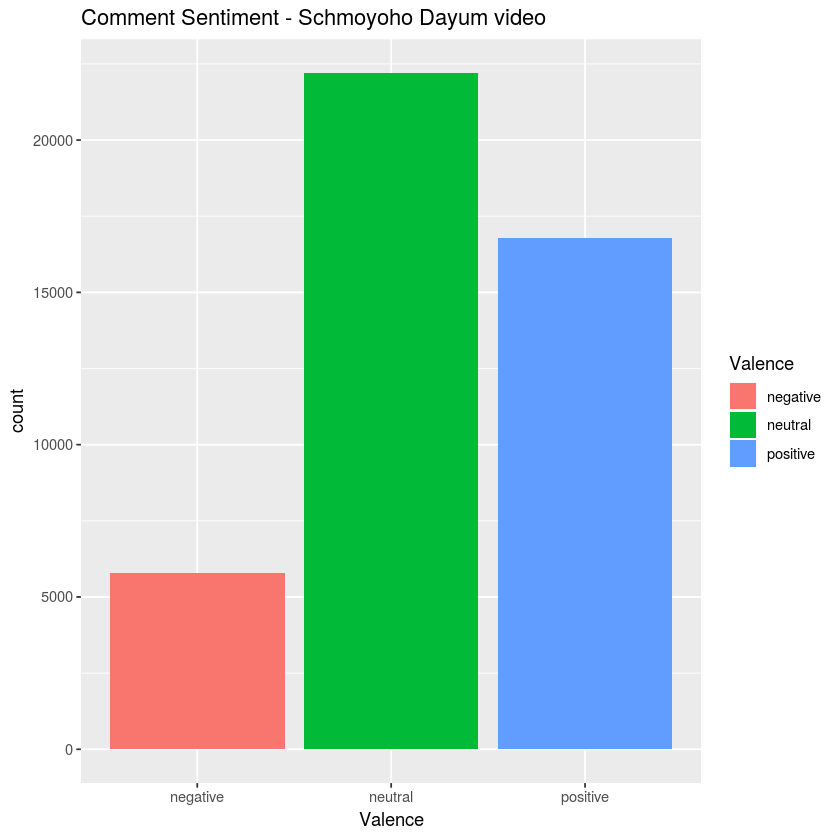

In [109]:
# build helper dataframe to distinguish between positive, negative and neutral comments
Desc <- CommentSentiment
Desc[Desc > 0] <- "positive"
Desc[Desc < 0] <- "negative"
Desc[Desc == 0] <- "neutral"
df <- data.frame(FormattedComments$TextEmojiDeleted,CommentSentiment,Desc)
colnames(df) <- c("Comment","Sentiment","Valence")

# display amount of positive, negative, and neutral comments
ggplot(data=df, aes(x=Valence, fill = Valence)) +
  geom_bar(stat='count') +
  ggtitle("Comment Sentiment - Schmoyoho Dayum video")

Warning message:
“Removed 145 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

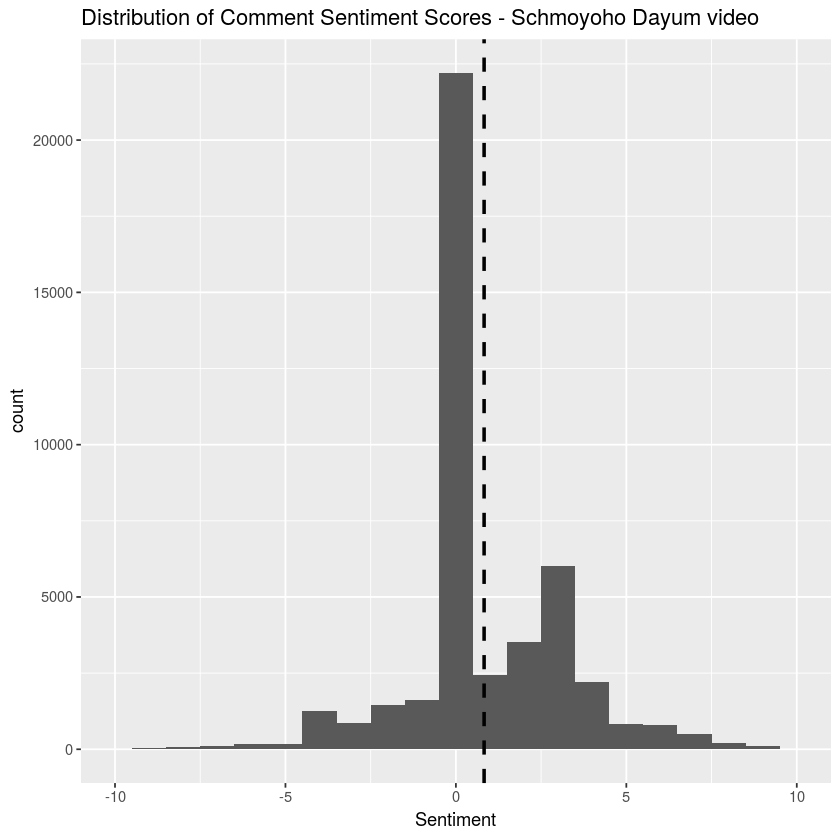

In [110]:
# distribution of comment sentiments (dotted line representd mean sentiment of all comments)
ggplot(df, aes(x=Sentiment)) +
  geom_histogram(binwidth = 1) +
  geom_vline(aes(xintercept=mean(Sentiment)),
             color="black", linetype="dashed", size=1) +
  ggtitle("Distribution of Comment Sentiment Scores - Schmoyoho Dayum video") +
  scale_x_continuous(limits=c(-10,10))

We can see that most comments seem to be neutral and we have more comments with positive sentiment than with negative sentiment

***

#### Basic Frequency Analysis for Emojis

Online communication is different from more traditional forms of written communication in many ways. One of those differences is the use of Emojis to express concepts and emotions. In many textual analyses, emojis are note used at all and simply discarded. In this notebook, we will have a look at the use of emojis as well. First of all, we need to make the Emojis usable. This has largely been done in the parsing step (see script for scraping and parsing the data), so we only need to do some minor preparations here.

**NOTE:** There is a persistent issue with encoding problems for emojis in R on Windows. We tested the code in this notebook on several Windows machines and it should work there as well. If the code does not work for you offline, windows encoding problems are a likely culprit. 

In [ ]:
# First, we need to define missing values correctly
FormattedComments$Emoji[FormattedComments$Emoji == "NA"] <- NA

# next, we remove spaces at the end of the string
FormattedComments$Emoji <- substr(FormattedComments$Emoji, 1, nchar(FormattedComments$Emoji)-1)

# then we tokenize Emoji descriptions (important for comments that contain more than one Emoji)
EmojiToks <- tokens(FormattedComments$Emoji)

# afterwards, we create an Emoji frequency matrix, excluding "NA" as a term
EmojiDfm <- dfm(EmojiToks, remove = "NA")

We now have a "document-emoji frequency matrix" and can treat the emojis just like we treated the other tokens in previous analyses. Lets check out the most requent emojis

In [111]:
# we list the most frequent Emojis in the comments
EmojiFreq <- textstat_frequency(EmojiDfm)
head(EmojiFreq, n = 25)

feature,frequency,rank,docfreq,group
emoji_facewithtearsofjoy,732,1,261,all
emoji_hamburger,343,2,44,all
emoji_frenchfries,177,3,19,all
emoji_smilingfacewithsunglasses,139,4,11,all
emoji_smilingface,116,5,7,all
emoji_fire,63,6,20,all
emoji_loudlycryingface,42,7,24,all
emoji_smilingfacewithheart-eyes,36,8,16,all
emoji_rollingonthefloorlaughing,33,9,19,all
emoji_redheart,31,10,22,all


Lets visualize the emoji frequencies

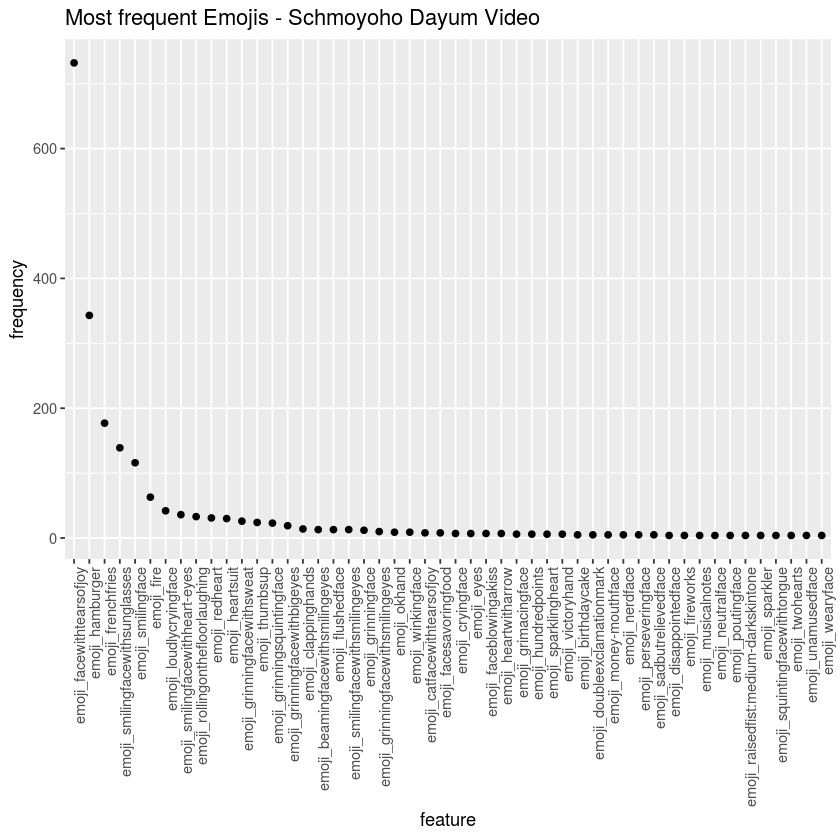

In [112]:
# Sort by reverse frequency order (i.e., from most to least frequent)
EmojiFreq$feature <- with(EmojiFreq, reorder(feature, -frequency))

# plot
ggplot(head(EmojiFreq, n = 50), aes(x = feature, y = frequency)) + # you can change n to choose how many Emojis are plotted 
  geom_point() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("Most frequent Emojis - Schmoyoho Dayum Video")

Intreestingly, just as words do, emojis seem to follow a Zipf-like distribution

https://en.wikipedia.org/wiki/Zipf%27s_law

However, our plot still looks a bit bland. Lets enrich it!

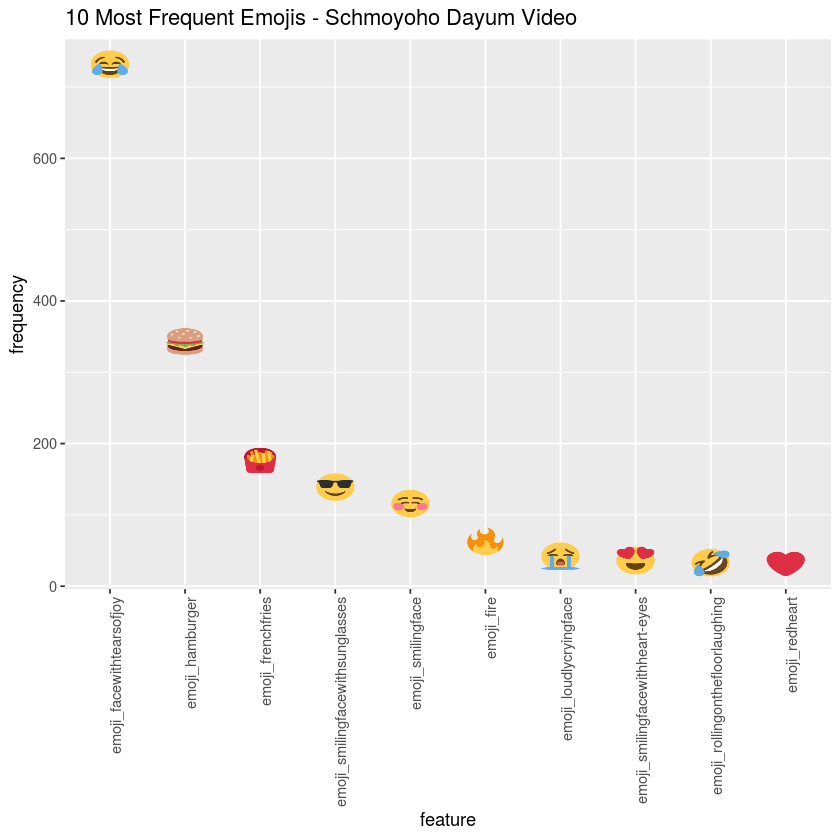

In [113]:
# creating mappings to display Scatterplot points as Emojis
mapping1 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_facewithtearsofjoy",], aes(feature,frequency), emoji = "1f602")
mapping2 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_hamburger",], aes(feature,frequency), emoji = "1f354")
mapping3 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_frenchfries",], aes(feature,frequency), emoji = "1f35f")
mapping4 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_smilingfacewithsunglasses",], aes(feature,frequency), emoji = "1f60e")
mapping5 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_smilingface",], aes(feature,frequency), emoji = "263a")
mapping6 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_fire",], aes(feature,frequency), emoji = "1f525")
mapping7 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_loudlycryingface",], aes(feature,frequency), emoji = "1f62d")
mapping8 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_smilingfacewithheart-eyes",], aes(feature,frequency), emoji = "1f60d")
mapping9 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_rollingonthefloorlaughing",], aes(feature,frequency), emoji = "1f923")
mapping10 <- geom_emoji(data = EmojiFreq[EmojiFreq$feature == "emoji_redheart",], aes(feature,frequency), emoji = "2764")

# Sort by reverse frequency order
EmojiFreq$feature <- with(EmojiFreq, reorder(feature, -frequency))

# Plotting x most common Emojis using their graphical representation as points in the scatterplot
ggplot(EmojiFreq[1:10], aes(x = feature, y = frequency)) +
  geom_point() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("10 Most Frequent Emojis - Schmoyoho Dayum Video") +
  mapping1 +
  mapping2 +
  mapping3 +
  mapping4 +
  mapping5 +
  mapping6 +
  mapping7 +
  mapping8 +
  mapping9 +
  mapping10


Just like with the text tokens, it might be that some comments contain a specific emoji numerous times and thus counting the overall frequency inflates the number of commenters that use the emoji. For this reason, we will also check the number of comments that each emoji is contained in.

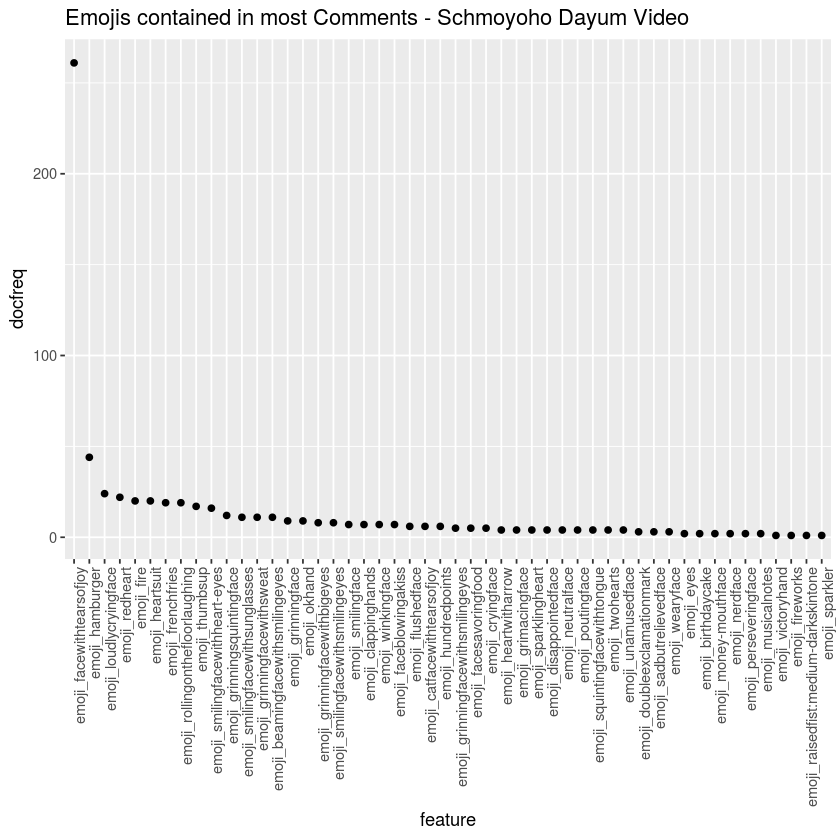

In [114]:
# sort by reverse document frequency order (i.e., from most to least frequent)
EmojiFreq$feature <- with(EmojiFreq, reorder(feature, -docfreq))

# plot
ggplot(head(EmojiFreq,n = 50), aes(x = feature, y = docfreq)) + # you can change n to choose how many Emojis are plotted 
  geom_point() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("Emojis contained in most Comments - Schmoyoho Dayum Video")

And we can also make this plot look cooler

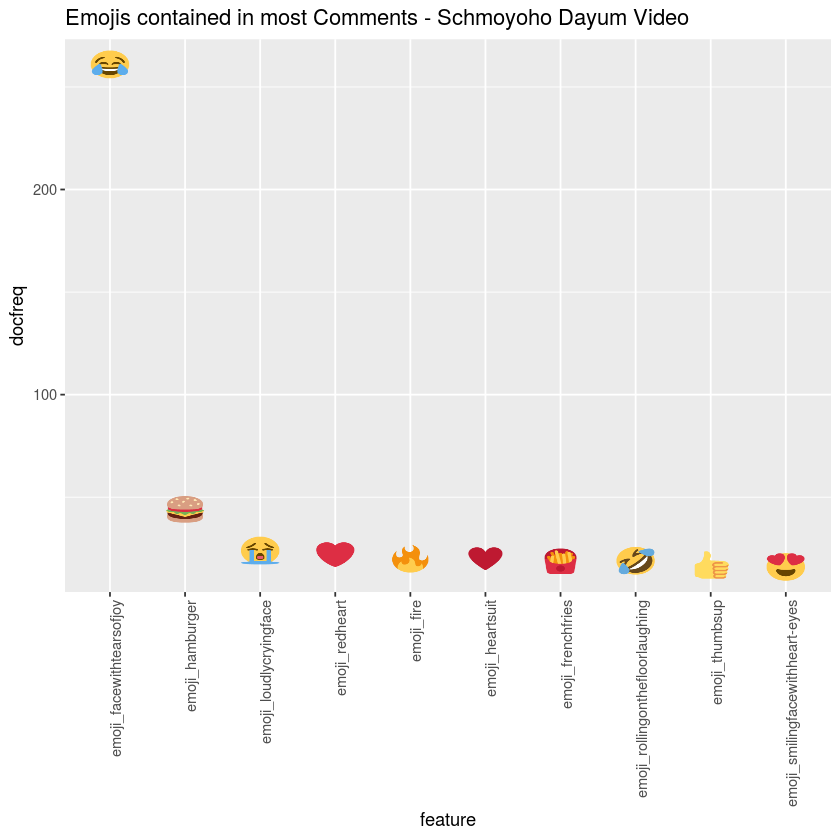

In [115]:
# Creating a new frame order by document occurance frequenc rather than overall frequency
NewOrder <- EmojiFreq[order(-EmojiFreq$docfreq),]

# creating mappings to display Scatterplot points as Emojis
mapping1 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_facewithtearsofjoy",], aes(feature,docfreq), emoji = "1f602")
mapping2 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_hamburger",], aes(feature,docfreq), emoji = "1f354")
mapping3 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_loudlycryingface",], aes(feature,docfreq), emoji = "1f62d")
mapping4 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_fire",], aes(feature,docfreq), emoji = "1f525")
mapping5 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_redheart",], aes(feature,docfreq), emoji = "2764")
mapping6 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_heartsuit",], aes(feature,docfreq), emoji = "2665")
mapping7 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_frenchfries",], aes(feature,docfreq), emoji = "1f35f")
mapping8 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_rollingonthefloorlaughing",], aes(feature,docfreq), emoji = "1f923")
mapping9 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_thumbsup",], aes(feature,docfreq), emoji = "1f44d")
mapping10 <- geom_emoji(data = NewOrder[NewOrder$feature == "emoji_smilingfacewithheart-eyes",], aes(feature,docfreq), emoji = "1f60d")

# Plotting 10 Emojis that most comments mention at least once
ggplot(NewOrder[1:10], aes(x = feature, y = docfreq)) +
  geom_point() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("Emojis contained in most Comments - Schmoyoho Dayum Video") +
  mapping1 +
  mapping2 +
  mapping3 +
  mapping4 +
  mapping5 +
  mapping6 +
  mapping7 +
  mapping8 +
  mapping9 +
  mapping10

***

#### Emoji Sentiment Analysis

Emojis are often used to confer emotions (hence the name), so they might be valuable addition
to assess the sentiment of a comment. Unfortunately, there are no established framework to
use sentiment analyses on Emojis to our knowledge. Therefore, our approach here will be largely
experimental. First of all, we need a dictionary that maps sentiment to specific Emojis

In [ ]:
# import Emoji dictionary
EmojiSentiments <- emojis_sentiment

Unfortunately, the dictionary only contains 734 different Emojis. However, those are by far the most frequently used ones.
You can view the Emoji sentiment scores online here

http://kt.ijs.si/data/Emoji_sentiment_ranking/index.html


We have to match the sentiment scores to our descriptions of the emojis, and create a quanteda dictionary object

In [ ]:
# Creating quanteda dictionary object
EmojiNames <- paste0("emoji_",gsub(" ","",EmojiSentiments$name))
EmojiSentiment <- cbind.data.frame(EmojiNames,EmojiSentiments$sentiment,EmojiSentiments$polarity)
names(EmojiSentiment) <- c("word","sentiment","valence")
EmojiSentDict <- as.dictionary(EmojiSentiment[,1:2])

In [ ]:
# we tokenize the Emoji-only column in our formatted dataframe
EmojiToks <- tokens(tolower(FormattedComments$Emoji))

In [ ]:
# We can now replace the Emojis that appear in the dictionary with the corresponding sentiment scores
EmojiToksSent <- tokens_lookup(x = EmojiToks, dictionary = EmojiSentDict)

We now have a vector of emoji sentiment scores for each column that we can use to analyze affective valence. But lets check first how many emojis we could and how many we couldn assign a sentiment score to

In [116]:
# total number of Emojis in the dataframe
AllEmoji <- unlist(EmojiToksSent)
names(AllEmoji) <- NULL
AllNonNAEmoji <- AllEmoji[AllEmoji!="NA"]
length(AllNonNAEmoji)

[1] 2122

In [117]:
# number of Emoji that could be assigned a sentiment score
length(grep("0.",AllNonNAEmoji))

[1] 2122

In [118]:
# Number of Emoji that could not be assigned a sentiment score
length(grep("emoji_",AllNonNAEmoji))

[1] 0

We could assign sentiment to all emojis in our data! Nice! Now we need to compute an overall metric for sentiment of each comment based on only the emojis

In [ ]:
# only keep the assigned sentiment scores for the Emoji vector
AllEmojiSentiments <- tokens_select(EmojiToksSent,EmojiSentiment$sentiment,"keep")
AllEmojiSentiments <- as.list(AllEmojiSentiments)

# define custom function to add up sentiment scores of Emojis per comment
AddEmojiSentiments <- function(x){
  
  x <- sum(as.numeric(as.character(x)))
  return(x)
  
}

# Applying the function to every comment that contains Emojis (only those Emojis that have a sentiment score will be used)
AdditiveEmojiSentiment <- lapply(AllEmojiSentiments,AddEmojiSentiments)
AdditiveEmojiSentiment[AdditiveEmojiSentiment == 0] <- NA
AdditiveEmojiSentiment <- unlist(AdditiveEmojiSentiment)

Lets plot the distribution of summed emoji sentiment per comment

Warning message:
“Removed 44233 rows containing non-finite values (stat_bin).”

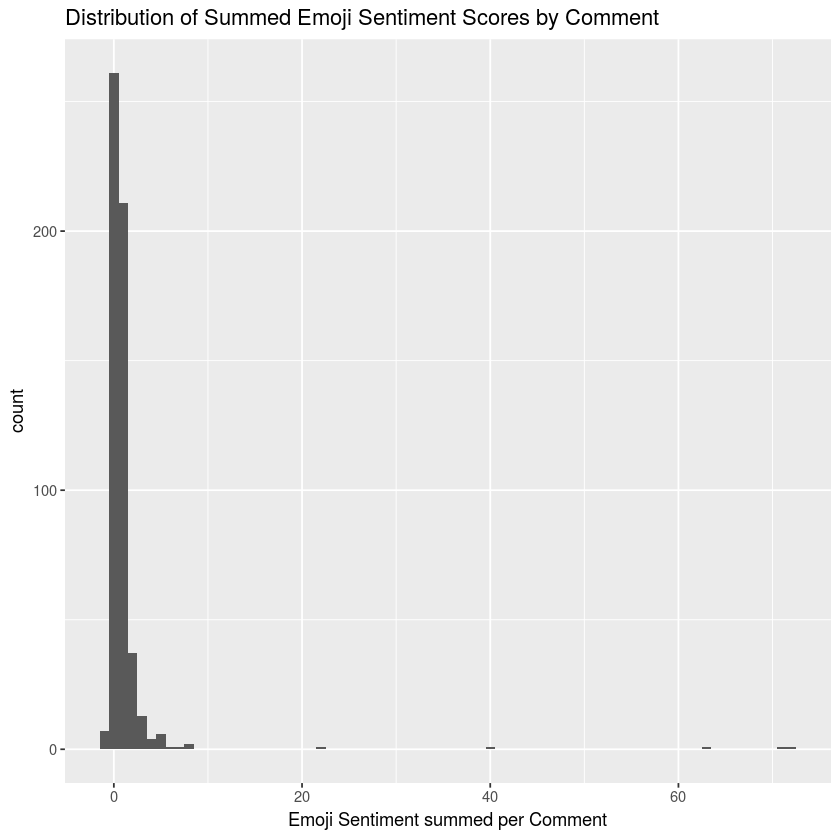

In [119]:
# plot histogram to check distribution of Emoji sentiment scores
AES_df <- data.frame(AdditiveEmojiSentiment)
ggplot(AES_df, aes(x = AES_df[,1])) +
  geom_histogram(binwidth = 1) +
  labs(title = "Distribution of Summed Emoji Sentiment Scores by Comment") +
  xlab("Emoji Sentiment summed per Comment")

We can see that most emoji sentiment sum scores are neutral or slightly positive. However, there are also some slightly negative scores and a few very positive outliers. Lets have a look at these comments

In [122]:
# show comments with negative Emoji sum scores
EmojiNegComments <- FormattedComments[AdditiveEmojiSentiment < 0,2]
as.list(EmojiNegComments[is.na(EmojiNegComments) == F])

[[1]]
[1] "This is so beautiful😭 no more words"

[[2]]
[1] "This is bring me back man 😭😭 still here in 2019"

[[3]]
[1] "Still bumps in 2019 😤"

[[4]]
[1] "Whoever did this deserves a Grammy. 😭😭"

[[5]]
[1] "People say the come this to be happy but it just makes me sad 😞"

[[6]]
[1] "Ace Videos me definitely made me go out and try five guys for the first time😭"

[[7]]
[1] "This is funny bro😭😭"

[[8]]
[1] "Lord I can’t breathe 😭"

[[9]]
[1] "Almost 6 years old 😭 they grow up so fast.."

[[10]]
[1] "Man i remember when this song first came out 😭 time flies way to fast."

[[11]]
[1] "I cant stop watching this 😭😭"

[[12]]
[1] "DAYUM I miss 2012😭"

[[13]]
[1] "Normal speed is calm 1.5 speed is better then 2x speed 😑"

[[14]]
[1] "I miss the old YouTube 😞"

[[15]]
[1] "Omfg right now I'm so freaking nostalgic... Missing 2k12 days so hard..😭"

[[16]]
[1] "am i the only one who wanted mcdonalds after watching this???😞😒😕"

[[17]]
[1] "Adam Andrews crazy, crazy, crazy nostalgia 😞"

[[18]]
[1] "Where have I been at???? 💀🤣🤣🤣🤣"

[[19]]
[1] "back when youtube was good. i miss the classics😔"

[[20]]
[1] "several years later and im here again... i was smiling during the whole video 😭"

[[21]]
[1] "This is my 💩"

[[22]]
[1] "wtf this fuck this video😠😬😡"

[[23]]
[1] "fuck you😒😠😡😬"

[[24]]
[1] "😐😒😠😡😧"

[[25]]
[1] "it's a sin if I wouldn't buy double cheeseburger with grocery bag 😣😣😣"

[[26]]
[1] "help i cant stop laughing\nhsud fhdvejcjbdudjendudb 😭"

[[27]]
[1] "I can make it happen now 🔫🔫🔫"

[[28]]
[1] "okay but where did he get the burger so we can taste that shit too😭😭"

[[29]]
[1] "you finto have to share that bro gimme some I want bacon 😭😭"

[[30]]
[1] "For some reason this is somewhat inspiring 😭"

[[31]]
[1] "DAYUM😩😫😩😫‼️‼️‼️"

[[32]]
[1] "+Janoria Corven I vill torture you if you argue with incompetent false 'statements' again. 😐"

[[33]]
[1] "My team was sucking it up in the Iron Banner and I started singing this...👿"

[[34]]
[1] "HE IS PUTTING FOOD ON THE SCREEN!!!!!!!!!!😖"

[[35]]
[1] "Why would people hate on this !😪:/"

[[36]]
[1] "DAYUM DAYUM DAYUM!!!😡"

[[37]]
[1] "SMH 😒"

In [123]:
# show comments with overly positive emoji sum scores
EmojiPosComments <- FormattedComments[AdditiveEmojiSentiment > 20,2]
as.list(EmojiPosComments[is.na(EmojiPosComments) == F])

[[1]]
[1] "cool song😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎😎"

[[2]]
[1] "Day um that a lot of bugers 🐊🐊🐊🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🧀🍔🍔🍔🍔🍔🍔🍔🍔🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍔🌮🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🌶🌶🌶🍑🍑🍑🍑🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔"

[[3]]
[1] "🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍔🍟🍟🍔🍟🍟🍔🍟🍔🍔🍟🍟🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍔🍔🍔🍔🍔🍟🍔🍟🍔🍔🍔🍔🍔🍔🍔🍔🍟🍟🍟🍔🍔🍔🍟🍟🍔🍔🍔🍔🍔🍟🍔🍟🍔🍟🍔🍟🍔🍔🍟🍟🍟🍟🍔🍟🍟🍟🍟🍔🍔🍔🍟🍟🍟🍟🍔🍔🍟🍔🍟🍟🍟🍟🍟🍔🍔🍟🍟🍔🍔🍟🍟🍟🍟🍟🍟🍟🍟🍟🍟🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔"

[[4]]
[1] "find the difference \n☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺😉☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺☺"

[[5]]
[1] "Oh my goodness. 🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍟🍟🍟🍟🍟🍟🍟🍟🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔🍔"

As we can see, especially the positice outliers seem to occur because the same emoji gets spammend multiple times in the same comment

***

#### Relationship between Text and Emoji Sentiment

If Emojis ar used to underline the affective valence of what a comment author wants to express, there should be a positive correlation between text sentiment and emoji sentiment. Lets check if that is the case

In [124]:
# correlation between additive Emoji sentiment score and text sentiment score
cor(CommentSentiment,AdditiveEmojiSentiment,use="complete.obs")

[1] 0.003164187

Warning message:
“Removed 44233 rows containing missing values (geom_point).”

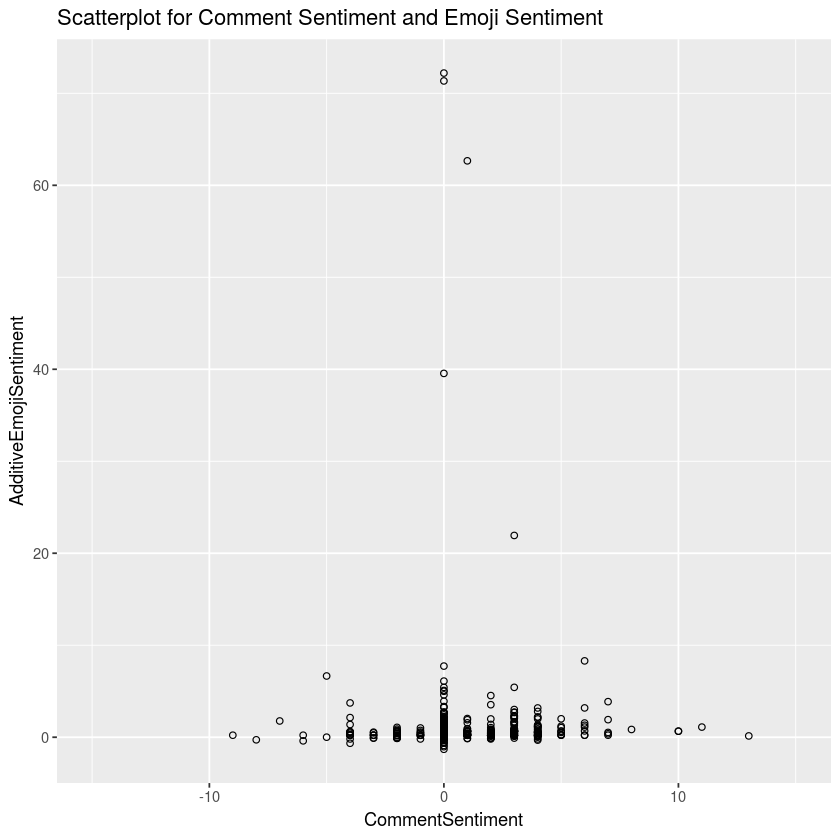

In [125]:
# plot the relationship
TextEmojiRel <- data.frame(CommentSentiment,AdditiveEmojiSentiment)
ggplot(TextEmojiRel, aes(x = CommentSentiment, y = AdditiveEmojiSentiment)) + geom_point(shape = 1) +
  ggtitle("Scatterplot for Comment Sentiment and Emoji Sentiment") +
  scale_x_continuous(limits=c(-15,15))

As we can see, there seems to be no relationship between the sentiment scores of the text and the sentiment
of the used Emojis. This can have multiple reasons:
  -  Comments that score very high (positive) on Emoji Sentiment typically contain very little text
  -  Comments that score very low  (negative) on Emoji Sentiment typically contain very few Emojis
  -  Sentiment analysis is not perfect, there is a lot of room for error in both metrics
  -  Most comment text sentiments and Emoji sentiments are neutral
  -  Emojis are very much context dependent: A laughing Emoji can mean very different things, depending on context
     (e.g. "This guy is hilarious" vs. "You're just pathetic"). However, we only consider a singular score for each Emoji
  -  High positive scores on the emoji sentiment are likely due to people spamming the same Emoji a lot  

We can try to make our metrics less dependent on the amount of Emojis or words in the comments by comparing average sentiment
per used word and per used Emoji for each comment

In [ ]:
# Average Sentiment score per word for each comment
WordsInComments <- sapply(FormattedComments$TextEmojiDeleted,function(x){A <- strsplit(x," ");return(length(A[[1]]))})
names(WordsInComments) <- NULL

# Computing average sentiment score per word instead of using the overall sum
AverageSentimentPerWord <- CommentSentiment/WordsInComments

# Saving a copy of the full vector for later
FullAverageSentimentPerWord <- AverageSentimentPerWord

# We exclude comments that do not have any words in them
AverageSentimentPerWord <- AverageSentimentPerWord[is.nan(AverageSentimentPerWord) == FALSE]

Lets see if our assessment is different now that we averaged sentiment scores by number of words

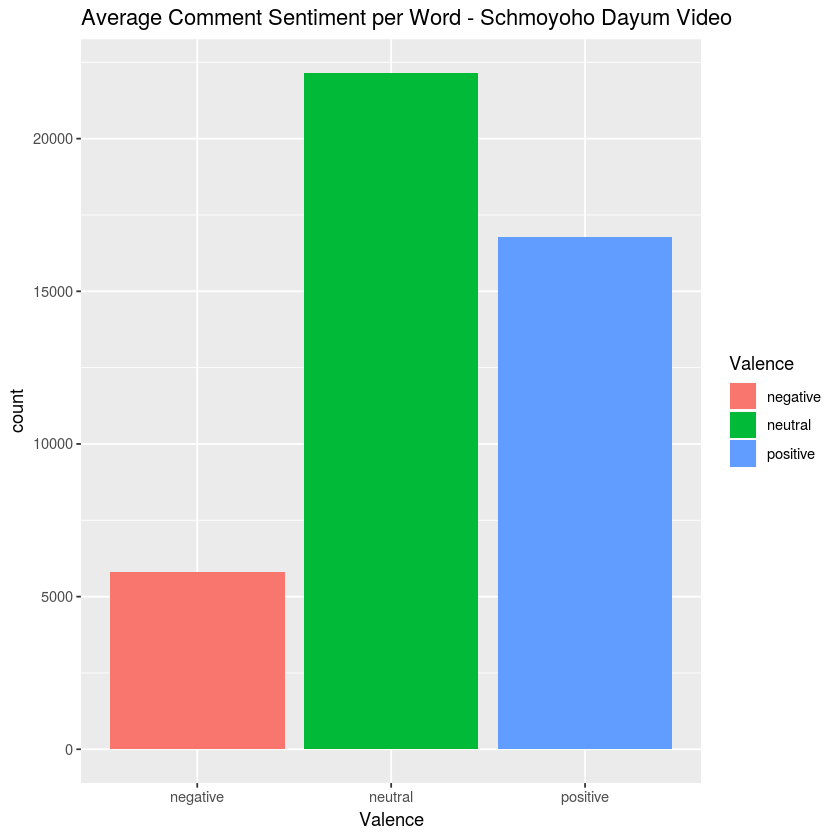

In [126]:
# build helper dataframe to distinguish between positive, negative and neutral comments
Desc <- AverageSentimentPerWord
Desc[Desc > 0] <- "positive"
Desc[Desc < 0] <- "negative"
Desc[Desc == 0] <- "neutral"
df <- data.frame(FormattedComments$TextEmojiDeleted[is.nan(FullAverageSentimentPerWord) == FALSE],AverageSentimentPerWord,Desc)
colnames(df) <- c("Comment","Sentiment","Valence")

# display amount of positive, negative, and neutral comments
ggplot(data=df, aes(x=Valence, fill = Valence)) +
  geom_bar(stat='count') +
  ggtitle("Average Comment Sentiment per Word - Schmoyoho Dayum Video")

Warning message:
“Removed 2 rows containing missing values (geom_bar).”

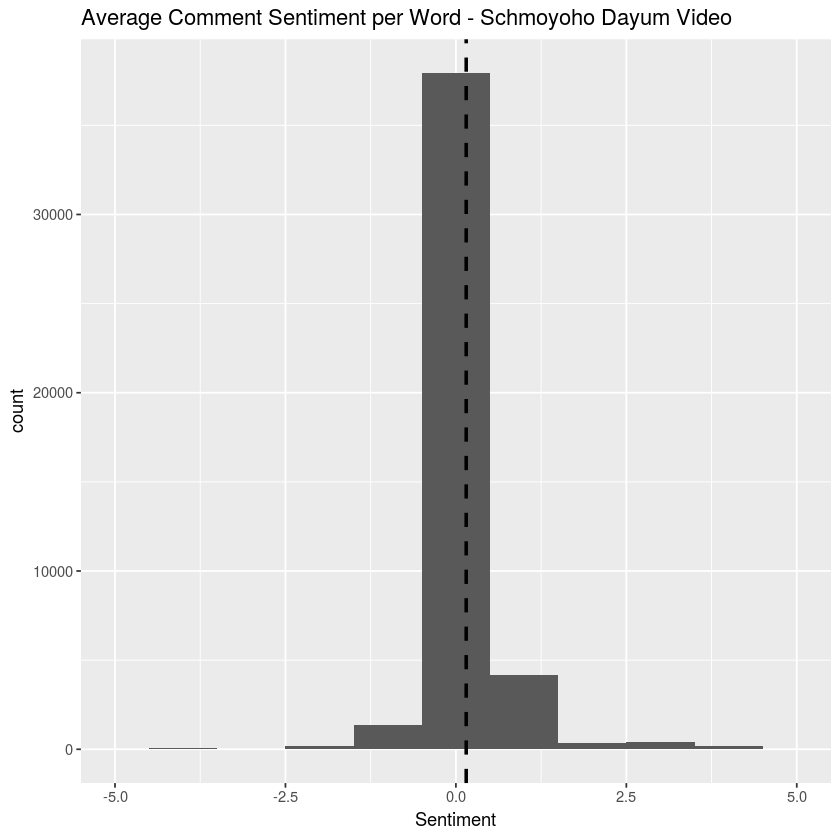

In [127]:
# distribution of comment sentiments (dotted line representd mean sentiment of all comments)
ggplot(df, aes(x=Sentiment)) +
  geom_histogram(binwidth = 1) +
  geom_vline(aes(xintercept=mean(Sentiment)),
             color="black", linetype="dashed", size=1) +
  ggtitle("Average Comment Sentiment per Word - Schmoyoho Dayum Video")+
  scale_x_continuous(limits=c(-5,5))

In [129]:
# display most negative/positive comment(s) (by average sentiment score per word)
as.list(df$Comment[AverageSentimentPerWord == min(AverageSentimentPerWord)])
as.list(df$Comment[AverageSentimentPerWord == max(AverageSentimentPerWord)])

[[1]]
[1] "DAMN"

[[2]]
[1] "Damn"

[[3]]
[1] "damn"

[[4]]
[1] "damn"

[[5]]
[1] "Damn~DaMN~DAYUMMMMMM"

[[6]]
[1] "DAMN"

[[7]]
[1] "WTF"

[[8]]
[1] "Damn"

[[9]]
[1] "Damn"

[[10]]
[1] "damn"

[[11]]
[1] "Damn!"

[[12]]
[1] "damn"

[[13]]
[1] "Damn"

[[14]]
[1] "WTF"

[[15]]
[1] "damn"

[[16]]
[1] "shit"

[[17]]
[1] "wtf"

[[18]]
[1] "DAMN"

[[19]]
[1] "Damn"

[[20]]
[1] "Damn"

[[21]]
[1] "Damn!"

[[22]]
[1] "DAMN!"

[[23]]
[1] "Damn"

[[24]]
[1] "Bullshit"

[[25]]
[1] "Damn!"

[[26]]
[1] "Damn."

[[27]]
[1] "wtf"

[[28]]
[1] "damn..."

[[29]]
[1] "damn"

[[30]]
[1] "Damn"

[[31]]
[1] "Damn"

[[32]]
[1] "Damn."

[[33]]
[1] "wtf"

[[34]]
[1] "Damn"

[[35]]
[1] "Damn...damn..damn..!!!"

[[36]]
[1] "Fuck"

[[37]]
[1] "Damn"

[[38]]
[1] "Wtf?"

[[39]]
[1] "Damn "

[[40]]
[1] "Damn. "

[[41]]
[1] "DAMN"

[[42]]
[1] "damn.. "

[[43]]
[1] "Damn!!!"

[[44]]
[1] "wtf"

[[45]]
[1] "damn "

[[46]]
[1] "Damn"

[[47]]
[1] "wtf"

[[48]]
[1] "wtf"

[[49]]
[1] "DAMN"

[[50]]
[1] "Wtf"

[[51]]
[1] "What...The...Fuck... "

[[52]]
[1] "Damn."

[[53]]
[1] "DAMN."

[[54]]
[1] "DAMN"

[[55]]
[1] "Wtf"

[[56]]
[1] "Damn"

[[57]]
[1] "Damn"

[[58]]
[1] "Damn"

[[59]]
[1] "Damn"

[[60]]
[1] "Damn..."

[[61]]
[1] "fuck"

[[62]]
[1] "DAMN!!"

[[63]]
[1] "damn"

[[64]]
[1] "Damn."

[[65]]
[1] "DAMN."

[[66]]
[1] "Racist Bastards..."

[[67]]
[1] "Damn...."

[[68]]
[1] "damn"

[[69]]
[1] "Damn"

[[70]]
[1] "Damn"

[[71]]
[1] "WTF!!"

[[72]]
[1] "DAMN!!"

[[73]]
[1] "Slogan:damn."

[[74]]
[1] "damn"

[[75]]
[1] "Damn"

[[76]]
[1] "damn"

[[77]]
[1] "DAMN!"

[[78]]
[1] "Damn."

[[79]]
[1] "damn"

[[80]]
[1] "*asshole"

[[81]]
[1] "asshole"

[[82]]
[1] "high-fucking-five!"

[[83]]
[1] "Damn."

[[84]]
[1] "wtf"

[[85]]
[1] "DAMN....."

[[86]]
[1] "DAMN!!"

[[87]]
[1] "Wtf"

[[88]]
[1] "WTF?!?!?!?!"

[[89]]
[1] "damn"

[[90]]
[1] "Damn!"

[[91]]
[1] "DAMN"

[[92]]
[1] "DAMN!!!!!!"

[[93]]
[1] "damn "

[[94]]
[1] "Racist prick."

[[1]]
[1] "(Nice/good/awesome remix)"

We now have very short comments with very few extreme words as the extreme ends of the spectrum. Lets have a look at the emojis as well

In [ ]:
## Computing average Emoji sentiment per Comment

# define custom function to add up sentiment scores of Emojis per comment (you have to highlight the whole function and run it as a whole)
AverageEmojiSentiments <- function(x){
  
  x <- mean(as.numeric(unlist(x)))
  return(x)
  
}

# Applying the function to every comment that contains Emojis (only those Emojis that have a sentiment score will be used)
AverageEmojiSentiment <- lapply(AllEmojiSentiments,AverageEmojiSentiments)

# saving a full copy for later
FullAverageEmojiSentiment <- unlist(AverageEmojiSentiment)

AverageEmojiSentiment[AverageEmojiSentiment == 0] <- NA
AverageEmojiSentiment <- unlist(AverageEmojiSentiment)

# We exclude comments that do not contain Emojis
AverageEmojiSentiment <- AverageEmojiSentiment[is.nan(AverageEmojiSentiment) == FALSE]

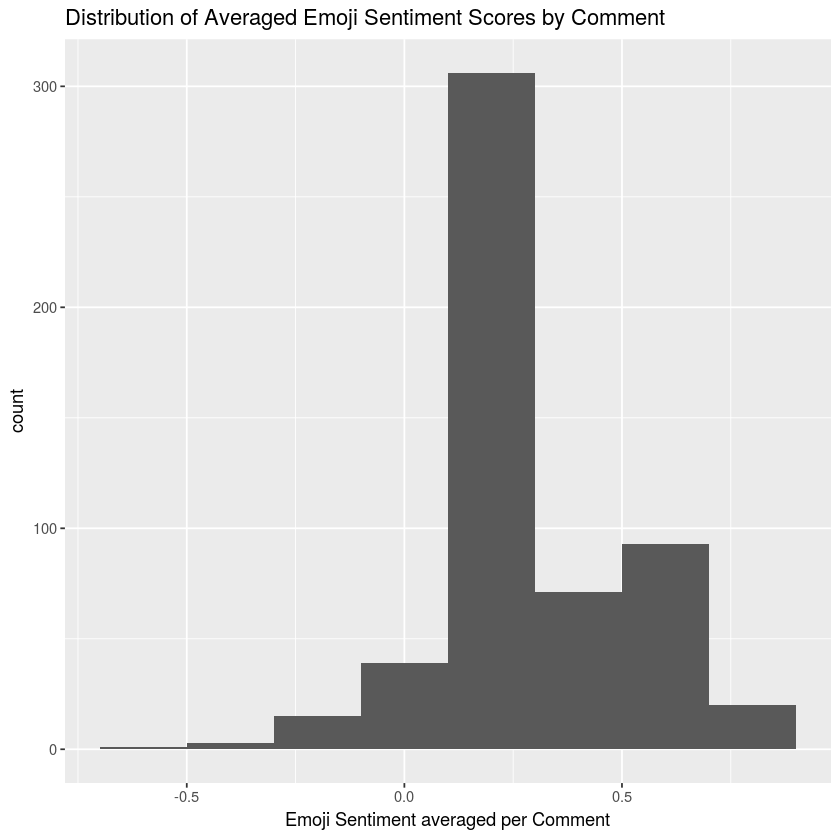

In [130]:
# plot histogram to check distribution of Emoji sentiment scores
AvES_df <- data.frame(AverageEmojiSentiment)
ggplot(AvES_df, aes(x = AvES_df[,1])) +
  geom_histogram(binwidth = 0.2) +
  labs(title = "Distribution of Averaged Emoji Sentiment Scores by Comment") +
  xlab("Emoji Sentiment averaged per Comment") 

Now that we have averaged both sentiment metrics, lets check whether it changed something in their bivariate distribution

In [131]:
# correlation between averaged Emoji sentiment score and averaged text sentiment score
cor(FullAverageSentimentPerWord,FullAverageEmojiSentiment,use="complete.obs")

[1] 0.1348859

Warning message:
“Removed 44269 rows containing missing values (geom_point).”

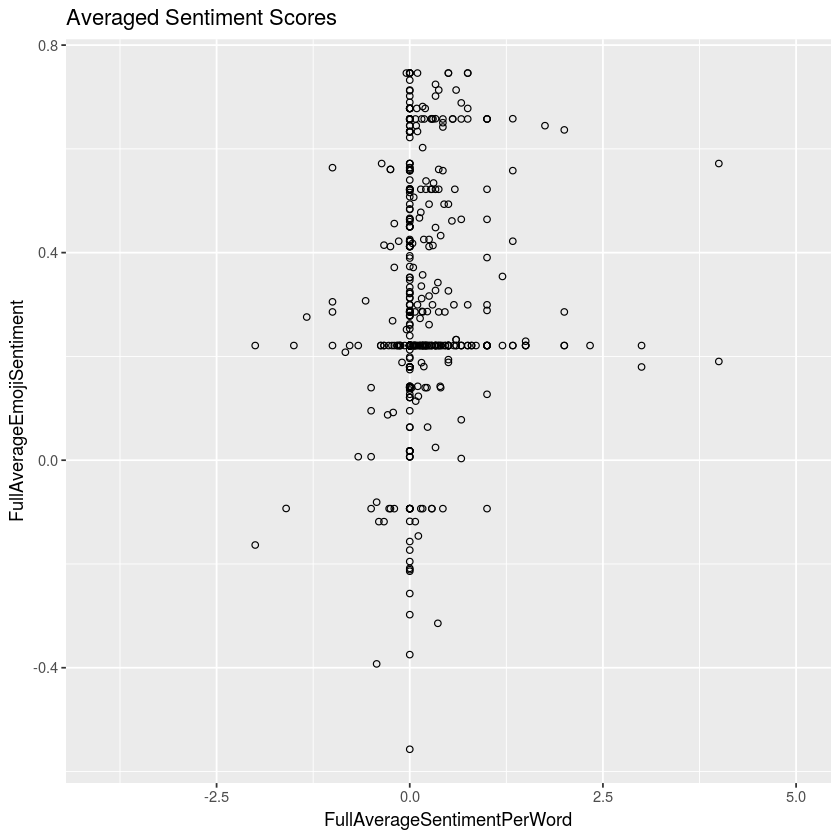

In [132]:
# plot the relationship
TextEmojiRel <- data.frame(FullAverageSentimentPerWord,FullAverageEmojiSentiment)
ggplot(TextEmojiRel, aes(x = FullAverageSentimentPerWord, y = FullAverageEmojiSentiment)) + geom_point(shape = 1) +
  ggtitle("Averaged Sentiment Scores")

We do obtain a larger positive correlation with the averaged measures, however visual inspection reveals
that there is no meaningful linear relationships. The data is clustered around one vertical line and multiple
horizontal lines. This is likely due to:

- skewed distribution of number of Emojis per Comments and types of Emojis used (e.g. using the ROFL Emoji exactly once is by far
  the most common case of Emoji use under this particular video)
- Most common Average Sentiment per Word is zero

Conclusion:
   - using Emojis in your textanalysis can give more context to your corpus
   - Simple dictonary analysis of sentiments does not work well for Emojis
   - In the future, approaches for sentiment analysis should integrate text and emoji in a metric that accounts for their
     interdepence
